# <span style="color:blue"> Data Processing and Segmentation with U-Net Model

This notebook is designed to process and segment data from the `data` folder located in the root directory. 

We will use a U-Net model for segmentation tasks, which is a popular architecture for image segmentation due to its ability to capture both local and global features effectively.

The notebook will guide you through the following steps:

1. **Imports and Setup**: Importing necessary libraries and setting up the environment.
2. **Data Loading and Visualization**: Loading the dataset and visualizing samples to understand the data.
3. **Defining the U-Net Architecture**: Implementing the U-Net model for segmentation.
4. **Training the Model**: Training the U-Net model on the dataset.
5. **Inference and Evaluation**: Testing the model on unseen data and evaluating its performance.

---

### <span style="color:brown"> What is Segmentation?

Segmentation is the process of assigning a class label to each pixel in an image. It can be:
- **Binary Segmentation**: Differentiating between an object and the background.
- **Multi-Class Segmentation**: Differentiating between multiple object classes.

In this notebook, we will focus on **semantic segmentation**, where all objects of the same class are assigned the same label.

---

### <span style="color:brown"> Overview of U-Net

The U-Net architecture is a fully convolutional network designed for segmentation tasks. It consists of:
- **Encoder Path**: Captures context and extracts features.
- **Decoder Path**: Reconstructs the segmentation map using the features extracted by the encoder.
- **Skip Connections**: Preserve spatial information by connecting corresponding layers in the encoder and decoder.

<img src="figures/UNet.png" alt="U-Net Architecture" style="width: 70%;"/>

## <span style="color:brown"> 1. Imports and Setup

In this section, we will import the necessary libraries and set up the environment for data processing and model training.

In [2]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from typing import Tuple, List, Dict
#import nibabel as nib
from torchvision import transforms
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## <span style="color:brown"> 2. Data Loading and Organization

In this section, we will organize the data into train, validation, and test sets based on patient IDs and create dataset objects for processing.

The `data` folder contains subfolders for each patient (e.g., `01016SACH`), and within each patient folder, there are files for different views and phases, such as:
- `TransformParameters.0.txt`: Metadata for transformations.
- `2CH_ED.nii.gz`: Image for the 2-chamber view at end-diastole.
- `2CH_ED_gt.nii.gz`: Ground truth segmentation for the corresponding image.
- Similar files for other views and phases (e.g., `2CH_ES`, `4CH_ED`, `4CH_ES`).

In [4]:
# Define helper function to list subdirectories
def subdirs(folder: str, join: bool = True, prefix: str = None, suffix: str = None, sort: bool = True) -> List[str]:
    if join:
        l = os.path.join
    else:
        l = lambda x, y: y
    res = [
        l(folder, i)
        for i in os.listdir(folder)
        if os.path.isdir(os.path.join(folder, i))
        and (prefix is None or i.startswith(prefix))
        and (suffix is None or i.endswith(suffix))
    ]
    if sort:
        res.sort()
    return res

# Specify the data directory
data_dir = Path("./data").resolve()

# List all patient IDs
patient_ids = subdirs(data_dir, join=False)

# Split patient IDs into train, validation, and test sets
train_ids, val_and_test_ids = train_test_split(patient_ids, train_size=0.8, random_state=12345)
val_ids, test_ids = train_test_split(val_and_test_ids, test_size=0.5, random_state=12345)

# Print dataset sizes
print(f"Train IDs: {len(train_ids)}")
print(f"Validation IDs: {len(val_ids)}")
print(f"Test IDs: {len(test_ids)}")

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\User\\3TC\\PIR\\2D UNet\\data'

### <span style="color:brown"> 2.1 Create Dataset Objects

We will now create dataset objects for the train, validation, and test sets. Each dataset will include paths to the images and their corresponding ground truth masks.

In [11]:
# Create datalists
def create_datalist(patient_ids: List[str], data_dir: Path) -> List[Dict[str, str]]:
    views = ["2CH_ED", "2CH_ES", "4CH_ED", "4CH_ES"]
    datalist = []
    for patient in patient_ids:
        patient_dir = data_dir / patient
        for view in views:
            image_path = patient_dir / f"{view}.nii.gz"
            label_path = patient_dir / f"{view}_gt.nii.gz"
            if image_path.exists() and label_path.exists():
                datalist.append({"image": str(image_path), "label": str(label_path)})
    return datalist

train_datalist = create_datalist(train_ids, data_dir)
val_datalist = create_datalist(val_ids, data_dir)
test_datalist = create_datalist(test_ids, data_dir)

# Print example datalist entries
print(f"Example train datalist entry: {train_datalist[0]}")
print(f"Example validation datalist entry: {val_datalist[0]}")
print(f"Example test datalist entry: {test_datalist[0]}")

IndexError: list index out of range

### <span style="color:brown"> 2.2 Define Dataset Class

We will define a custom dataset class to handle loading and preprocessing of the images and masks.

FileNotFoundError: No such file or no access: 'C:/Users/User/3TC/PIR/data/07040DORE/07040DORE_2CH_ED.nii.gz'

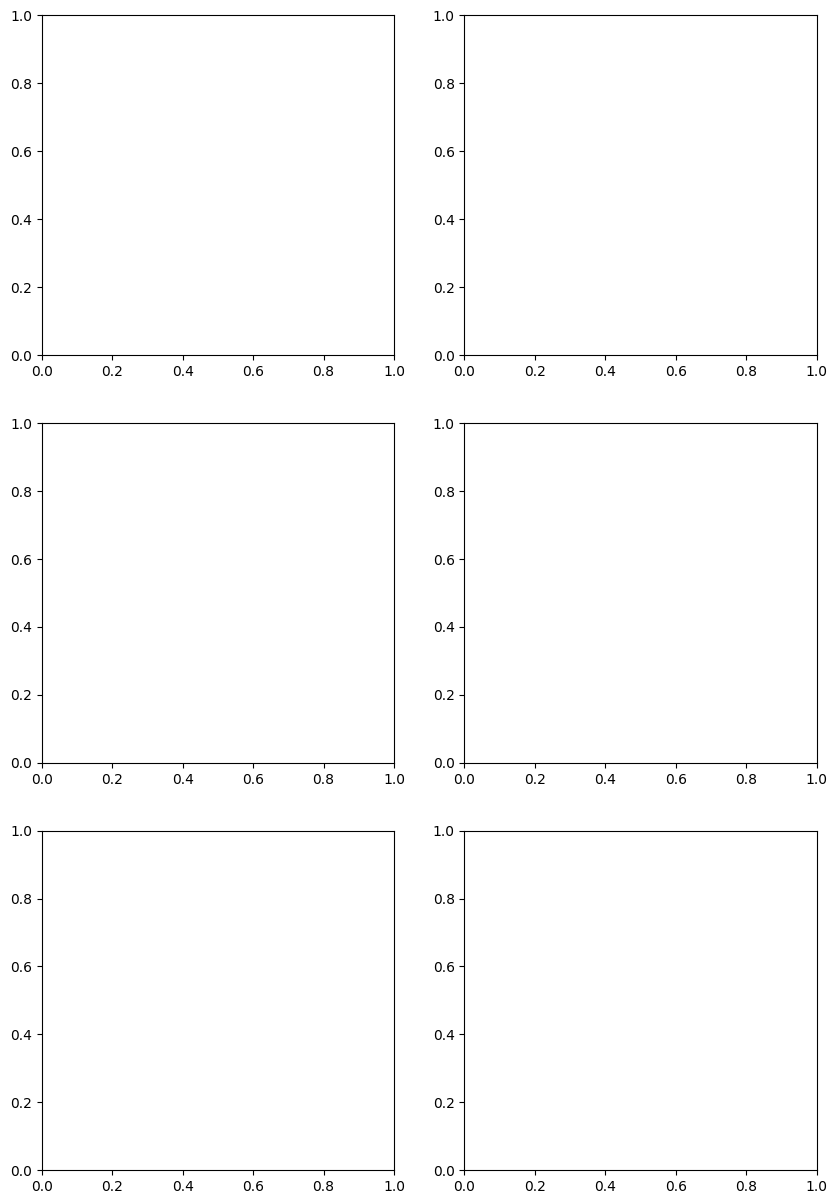

In [8]:
class MedicalImageDataset(Dataset):
    def __init__(self, datalist: List[Dict[str, str]], transform: transforms.Compose):
        self.datalist = datalist
        self.transform = transform

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        item = self.datalist[idx]
        image = nib.load(item['image']).get_fdata()
        label = nib.load(item['label']).get_fdata()

        # Normalize image and convert to PIL for transformations
        image = (image / np.max(image) * 255).astype(np.uint8)
        label = label.astype(np.uint8)
        image = Image.fromarray(image)
        label = Image.fromarray(label)

        # Apply transformations
        image, label = self.transform((image, label))

        return image, label

# Define transformations
class ResizeImageAndMask:
    def __init__(self, image_size, mask_size):
        self.image_resize = transforms.Resize(image_size, interpolation=Image.BILINEAR)
        self.mask_resize = transforms.Resize(mask_size, interpolation=Image.NEAREST)

    def __call__(self, sample):
        image, mask = sample
        image = self.image_resize(image)
        mask = self.mask_resize(mask)
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

transform = ResizeImageAndMask((128, 128), (128, 128))

# Create datasets
train_dataset = MedicalImageDataset(train_datalist, transform)
val_dataset = MedicalImageDataset(val_datalist, transform)
test_dataset = MedicalImageDataset(test_datalist, transform)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

### <span style="color:brown"> 2.2 Visualize Samples

Let's visualize some samples from the dataset to ensure that the images and masks are loaded correctly.

In [ ]:
# Visualize samples
def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[i]
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title('Image')
        axes[i, 1].imshow(mask.squeeze(), cmap='jet')
        axes[i, 1].set_title('Mask')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

## <span style="color:brown"> 3. Define the U-Net Architecture

We will now define the U-Net architecture for segmentation. The U-Net consists of an encoder-decoder structure with skip connections.

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, padding=1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model
model = UNet(in_channels=1, out_channels=2).to(device)
print(model)

## <span style="color:brown"> 4. Train the Model

We will now train the U-Net model using the training dataset. The training loop will include:
- Forward pass
- Loss computation
- Backward pass
- Optimizer step

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

## <span style="color:brown"> 5. Inference and Evaluation

Finally, we will test the model on the test dataset and evaluate its performance using metrics like Dice coefficient and IoU.

In [ ]:
# Define evaluation metrics
def dice_coefficient(pred, target):
    smooth = 1e-6
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Evaluate on test dataset
model.eval()
dice_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        dice = dice_coefficient(preds, masks)
        dice_scores.append(dice.item())

print(f"Average Dice Coefficient: {np.mean(dice_scores):.4f}")